In [1]:
import IPython
import IPython.display
import keras
from keras.layers import Conv1D
from keras.layers import Dense
from keras.layers import Input
from keras.layers import MaxPooling1D
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [2]:
## Load data
with open('../data/pickled_data/AEK201_short.pkl', 'rb') as f:
    df = pickle.load(f)

## Grab desired columns
#df = df[['date', 'avg_well_depth', 'gage_ht', 'discharge_cfs', 'prcp',
#       'temp_avg', 'temp_max', 'temp_min', 'hPa_avg', 'hum_avg', 'hum_max',
#       'hum_min', 'wind_avg', 'wind_max', 'wind_min', 'gust_avg', 'gust_max']]

df = df[['date', 'avg_well_depth', 'gage_ht', 'discharge_cfs', 'prcp',
         'temp_avg', 'hum_avg', 'hPa_avg', 'wind_avg', 'gust_avg']]
## Pop off date_time information
date_time = pd.to_datetime(df.pop('date'), format='%d.%m.%Y %H:%M:%S')

## Add _time of year_ signal
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

## Set aside holdout data
all_date_time = date_time.copy()

date_time_holdout = date_time[-365:].copy()
df_holdout = df[-365:].copy()

date_time = date_time[:-365].copy()
df = df[:-365].copy()

In [3]:
## Define some helpf functions for plotting data

def plot_dfs(train, test, pred, train_limit=None, normalized=False):

    dt_train = date_time[:train.shape[0]]
    dt_test = date_time[train.shape[0]:train.shape[0]+test.shape[0]]
    
    if train_limit==None:
        train_limit = len(train)
    
    plt.figure(figsize=(12,6))

    ## Plot the training data
    plt.plot(dt_train[-train_limit:], train.avg_well_depth[-train_limit:],
                 label='Train',  marker='.',  zorder=-10)

    ## Plot the test data
    plt.scatter(dt_test, test.avg_well_depth, edgecolors='k', linewidth=0.1,
                    c='#ff7f0e',  alpha =1, s=24, label='Test')
    
    ## Plot the prediction
    plt.scatter(dt_test, pred, marker='X', edgecolors='k', linewidth=0.1,
                    c='red', alpha =.75, s=24, label='Prediction')
    
    if normalized:
        plt.title('Water Depth from the Surface [Normalized]', fontsize = 16)
        plt.ylabel('Feet Below Surface [Normalized]', fontsize=14)
    else:    
        plt.title('Water Depth from the Surface', fontsize = 16)
        plt.ylabel('Feet Below Surface', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.legend(fontsize = 14)

    plt.show()

def plot_arrays(train, test, pred, train_limit=None, normalized=False):
    
    if train_limit==None:
        train_limit = len(train)
    
    plt.figure(figsize=(12,6))

    dt_train = date_time[:train.shape[0]]
    dt_test = date_time[train.shape[0]:train.shape[0]+test.shape[0]]
    
    ## Plot the training data
    plt.plot(dt_train[-train_limit:], train[-train_limit:],
                 label='Train',  marker='.', zorder=-10)

    ## Plot the test data
    plt.scatter(dt_test, test, edgecolors='k', linewidth=0.1,
                    c='#ff7f0e',  alpha =1, s=24, label='Test')
    
    ## Plot the prediction
    plt.scatter(dt_test, pred,  marker='X', edgecolors='k', linewidth=0.1,
                    c='red', alpha =.75, s=24, label='Prediction')
    
    if normalized:
        plt.title('Water Depth from the Surface [Normalized]', fontsize = 16)
        plt.ylabel('Feet Below Surface [Normalized]', fontsize=14)
    else:    
        plt.title('Water Depth from the Surface', fontsize = 16)
        plt.ylabel('Feet Below Surface', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.legend(fontsize = 14)

    plt.show()

In [4]:
## Get the original data
time_train = date_time.copy()
data_train = df.copy()

## Separate the input and output data
X = data_train.drop('avg_well_depth', axis=1).copy()
y = data_train.avg_well_depth.copy()

In [5]:
## Hyper-parameters
# Cross validation
N_SPLITS = 5

## make_cnn
C1_FILTERS = 370
C1_KERNEL = 1250
C2_FILTERS = 1000
C2_KERNEL = 5000
C3_FILTERS = 1000
C3_KERNEL = 100000
D1_UNITS = 1500
D2_UNITS = 300
D3_UNITS = 20
D4_UNITS = 5
OPTIMIZER = tf.keras.optimizers.legacy.Adam(learning_rate=0.000075)
LOSS = 'mean_squared_error'

## kr
EPOCHS = 75
BATCH_SIZE = 64

In [6]:
## Make the model
def make_cnn(X_train, 
                 C1_FILTERS = C1_FILTERS, C1_KERNEL = C1_KERNEL,
                 C2_FILTERS = C2_FILTERS, C2_KERNEL = C2_KERNEL,
                 C3_FILTERS = C3_FILTERS, C3_KERNEL = C3_KERNEL,
                 D1_UNITS = D1_UNITS, D2_UNITS = D2_UNITS,
                 OPTIMIZER = OPTIMIZER,
                 LOSS = LOSS):

    ## Define the layers 
    ## Input layer
    model = Sequential()
    
    ## Input layer
    model.add(Input(shape=(X_train.shape[1],X_train.shape[2])))
    
    ## Convolutional laters
    model.add(Conv1D(filters=C1_FILTERS, kernel_size=C1_KERNEL, strides=1, padding='same', activation='relu'))
    #model.add(Conv1D(filters=C2_FILTERS, kernel_size=C1_KERNEL, strides=1, padding='same', activation='relu'))
    #model.add(Conv1D(filters=C3_FILTERS, kernel_size=C1_KERNEL, strides=1, padding='same', activation='relu'))
    
    ## Flattening layer
    model.add(Flatten())
    
    ## Dense Layers
    model.add(Dense(D1_UNITS, activation='relu'))
    model.add(Dense(D2_UNITS, activation='relu'))
    model.add(Dense(D3_UNITS, activation='relu'))
    model.add(Dense(D4_UNITS, activation='relu'))
    
    ## Output Layer
    model.add(Dense(1, activation='linear'))
    
    ## Compile the model
    model.compile(optimizer = OPTIMIZER,
                      loss = LOSS)
    
    ## Return the model
    return model

## Wrap the model so that sklearn can use it:
kr = KerasRegressor(build_fn=make_cnn, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                    loss = LOSS, 
                    verbose=1)

In [7]:
## Run the model

## For splitting the data
splitter = TimeSeriesSplit(n_splits=N_SPLITS, test_size=365, gap=0)

## For scaling the data
scaler =  StandardScaler(copy=True)

pipe = Pipeline([('scaler', scaler), 
                     ('kr', kr)])

## Cross validate
mses_cnn = np.zeros(N_SPLITS)
i = 0
for train, test in splitter.split(X, y):
    ## Split the data into train/test sets
    X_tt = X.iloc[train].values
    y_tt = y.iloc[train].values
    X_ho = X.iloc[test].values
    y_ho = y.iloc[test].values

    ## Reshape for the CNN
    X_tt_series = X_tt.reshape((X_tt.shape[0], X_tt.shape[1], 1))

    #default_params = {'CNN__X_train':'X_tt_series'}
    pipe.set_params(kr__model=make_cnn(X_tt_series))    
    pipe.fit(X_tt,y_tt)

    ## Make predictions
    pred = pipe.predict(X_ho)

    ## Score the model
    mse = mean_squared_error(y_ho, pred)
    mses_cnn[i] = mse

    i += 1

2023-11-06 11:36:00.863265: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-11-06 11:36:00.863290: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2023-11-06 11:36:00.863294: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2023-11-06 11:36:00.863330: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-06 11:36:00.863347: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/75
 1/33 [..............................] - ETA: 9s - loss: 4394.9214

2023-11-06 11:36:01.241848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 1s 10ms/step - loss: 4358.6807
Epoch 2/75
33/33 [==============================] - 0s 7ms/step - loss: 3704.4758
Epoch 3/75
33/33 [==============================] - 0s 8ms/step - loss: 1429.8112
Epoch 4/75
33/33 [==============================] - 0s 8ms/step - loss: 159.9034
Epoch 5/75
33/33 [==============================] - 0s 8ms/step - loss: 109.1422
Epoch 6/75
33/33 [==============================] - 0s 7ms/step - loss: 89.0332
Epoch 7/75
33/33 [==============================] - 0s 8ms/step - loss: 73.7827
Epoch 8/75
33/33 [==============================] - 0s 7ms/step - loss: 61.8112
Epoch 9/75
33/33 [==============================] - 0s 7ms/step - loss: 51.4959
Epoch 10/75
33/33 [==============================] - 0s 7ms/step - loss: 43.4039
Epoch 11/75
33/33 [==============================] - 0s 7ms/step - loss: 36.7583
Epoch 12/75
33/33 [==============================] - 0s 7ms/step - loss: 31.4071
Epoch 13/75
33/33 [====================

2023-11-06 11:36:20.348680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 7/38 [====>.........................] - ETA: 0s - loss: 4279.3687

2023-11-06 11:36:20.577674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 1s 9ms/step - loss: 1633.1707
Epoch 2/75
38/38 [==============================] - 0s 7ms/step - loss: 90.3021
Epoch 3/75
38/38 [==============================] - 0s 8ms/step - loss: 42.1856
Epoch 4/75
38/38 [==============================] - 0s 7ms/step - loss: 28.4118
Epoch 5/75
38/38 [==============================] - 0s 7ms/step - loss: 19.8207
Epoch 6/75
38/38 [==============================] - 0s 8ms/step - loss: 15.2369
Epoch 7/75
38/38 [==============================] - 0s 7ms/step - loss: 12.1146
Epoch 8/75
38/38 [==============================] - 0s 8ms/step - loss: 9.8849
Epoch 9/75
38/38 [==============================] - 0s 7ms/step - loss: 8.0053
Epoch 10/75
38/38 [==============================] - 0s 8ms/step - loss: 6.7036
Epoch 11/75
38/38 [==============================] - 0s 8ms/step - loss: 5.7263
Epoch 12/75
38/38 [==============================] - 0s 7ms/step - loss: 4.9014
Epoch 13/75
38/38 [==============================] 

2023-11-06 11:36:42.321756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 7/44 [===>..........................] - ETA: 0s - loss: 4382.4209

2023-11-06 11:36:42.541812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - 1s 9ms/step - loss: 1920.8374
Epoch 2/75
44/44 [==============================] - 0s 7ms/step - loss: 91.5966
Epoch 3/75
44/44 [==============================] - 0s 7ms/step - loss: 42.1201
Epoch 4/75
44/44 [==============================] - 0s 7ms/step - loss: 27.0594
Epoch 5/75
44/44 [==============================] - 0s 7ms/step - loss: 19.3143
Epoch 6/75
44/44 [==============================] - 0s 8ms/step - loss: 14.5637
Epoch 7/75
44/44 [==============================] - 0s 7ms/step - loss: 11.4068
Epoch 8/75
44/44 [==============================] - 0s 7ms/step - loss: 9.1980
Epoch 9/75
44/44 [==============================] - 0s 7ms/step - loss: 7.5479
Epoch 10/75
44/44 [==============================] - 0s 8ms/step - loss: 6.2710
Epoch 11/75
44/44 [==============================] - 0s 7ms/step - loss: 5.2368
Epoch 12/75
44/44 [==============================] - 0s 7ms/step - loss: 4.4184
Epoch 13/75
44/44 [==============================] 

2023-11-06 11:37:07.681135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 6/50 [==>...........................] - ETA: 0s - loss: 4400.1157 

2023-11-06 11:37:07.892111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 9ms/step - loss: 1343.3929
Epoch 2/75
50/50 [==============================] - 0s 7ms/step - loss: 60.9886
Epoch 3/75
50/50 [==============================] - 0s 7ms/step - loss: 29.4313
Epoch 4/75
50/50 [==============================] - 0s 8ms/step - loss: 18.6813
Epoch 5/75
50/50 [==============================] - 0s 7ms/step - loss: 13.0802
Epoch 6/75
50/50 [==============================] - 0s 7ms/step - loss: 9.5614
Epoch 7/75
50/50 [==============================] - 0s 7ms/step - loss: 7.4627
Epoch 8/75
50/50 [==============================] - 0s 7ms/step - loss: 5.7617
Epoch 9/75
50/50 [==============================] - 0s 7ms/step - loss: 4.6750
Epoch 10/75
50/50 [==============================] - 0s 7ms/step - loss: 3.7388
Epoch 11/75
50/50 [==============================] - 0s 7ms/step - loss: 3.1235
Epoch 12/75
50/50 [==============================] - 0s 7ms/step - loss: 2.6569
Epoch 13/75
50/50 [==============================] - 

2023-11-06 11:37:35.735160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 6/56 [==>...........................] - ETA: 0s - loss: 4396.9673 

2023-11-06 11:37:35.952086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 1s 9ms/step - loss: 1328.9347
Epoch 2/75
56/56 [==============================] - 0s 7ms/step - loss: 54.1673
Epoch 3/75
56/56 [==============================] - 0s 8ms/step - loss: 26.5943
Epoch 4/75
56/56 [==============================] - 0s 7ms/step - loss: 17.3608
Epoch 5/75
56/56 [==============================] - 0s 7ms/step - loss: 11.4141
Epoch 6/75
56/56 [==============================] - 0s 7ms/step - loss: 8.4369
Epoch 7/75
56/56 [==============================] - 0s 7ms/step - loss: 6.3194
Epoch 8/75
56/56 [==============================] - 0s 7ms/step - loss: 5.0973
Epoch 9/75
56/56 [==============================] - 0s 8ms/step - loss: 3.9587
Epoch 10/75
56/56 [==============================] - 0s 7ms/step - loss: 3.1380
Epoch 11/75
56/56 [==============================] - 0s 7ms/step - loss: 2.6253
Epoch 12/75
56/56 [==============================] - 0s 7ms/step - loss: 2.2223
Epoch 13/75
56/56 [==============================] - 

2023-11-06 11:38:07.619874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [8]:
mses_cnn

array([0.64252398, 0.26219187, 0.32670193, 0.48898887, 0.25333362])

6/6 [==============================] - 0s 5ms/step
The last model in trained had a mean square error of 0.2533336229662256


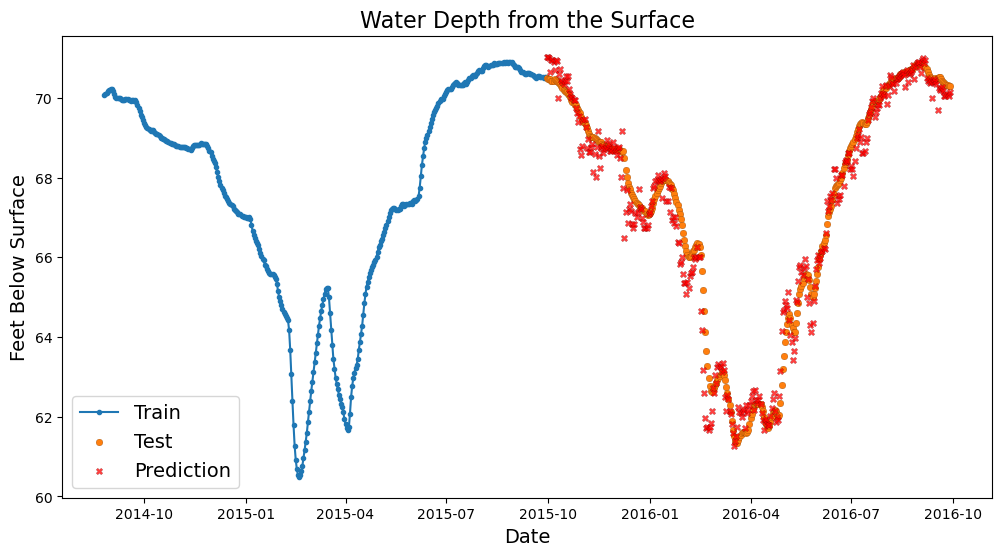

In [9]:
## Score the last model and output the result
pred = pipe.predict(X_ho)
score = mean_squared_error(y_ho, pred)
print(f'The last model in trained had a mean square error of {score}')
plot_arrays(y_tt,y_ho,pred, train_limit=400)

Epoch 1/75
 6/61 [=>............................] - ETA: 0s - loss: 4405.5698 

2023-11-06 11:38:08.036697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


61/61 [==============================] - 1s 9ms/step - loss: 1233.4747
Epoch 2/75
61/61 [==============================] - 0s 7ms/step - loss: 51.8330
Epoch 3/75
61/61 [==============================] - 0s 7ms/step - loss: 25.9098
Epoch 4/75
61/61 [==============================] - 0s 7ms/step - loss: 16.4539
Epoch 5/75
61/61 [==============================] - 0s 8ms/step - loss: 11.2143
Epoch 6/75
61/61 [==============================] - 0s 7ms/step - loss: 8.1115
Epoch 7/75
61/61 [==============================] - 0s 7ms/step - loss: 6.0572
Epoch 8/75
61/61 [==============================] - 409s 7s/step - loss: 4.7066
Epoch 9/75
61/61 [==============================] - 0s 8ms/step - loss: 3.7258
Epoch 10/75
61/61 [==============================] - 0s 7ms/step - loss: 2.9879
Epoch 11/75
61/61 [==============================] - 0s 7ms/step - loss: 2.4342
Epoch 12/75
61/61 [==============================] - 0s 7ms/step - loss: 2.0333
Epoch 13/75
61/61 [==============================] -

2023-11-06 11:47:01.095822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


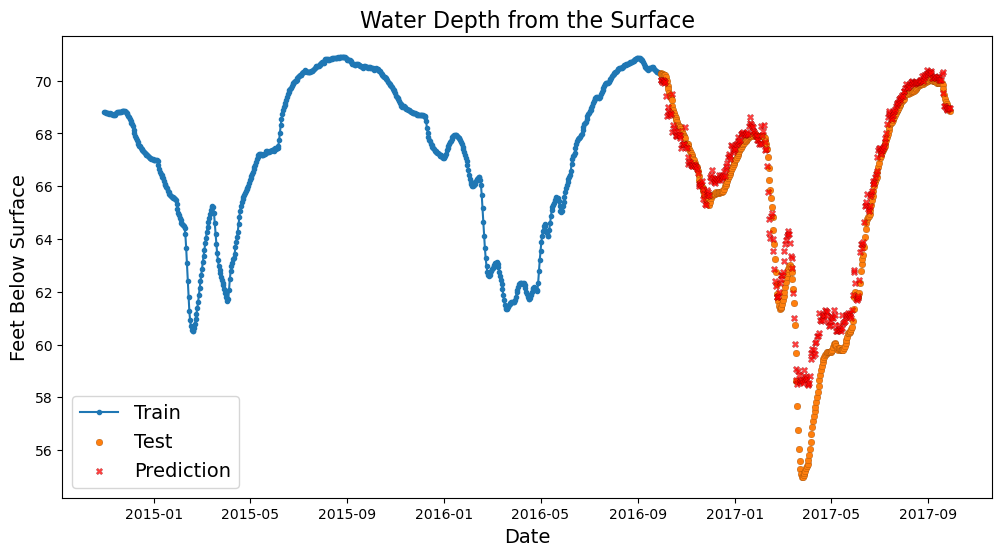

In [10]:
## Training on the whole data set
## Testing on the holdout set
date_time = all_date_time.copy()

X_train = data_train.drop('avg_well_depth', axis=1).copy().values
y_train = data_train.avg_well_depth.copy().values
X_holdout = df_holdout.drop('avg_well_depth', axis=1).copy().values
y_holdout = df_holdout.avg_well_depth.copy().values

X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
pipe.set_params(kr__model=make_cnn(X_train_series))    
pipe.fit(X_train,y_train)

pred = pipe.predict(X_holdout)
score = mean_squared_error(y_holdout, pred)

print(f'This model has a mean square error of {score} when evaluated on the holdout data')
plot_arrays(y_train,y_holdout, pred, train_limit=700)